# Yolo training format transform
- Github [Reference](https://github.com/ultralytics/yolov3/wiki/Example:-Train-Single-Class)
- Use label tool : [Labelbox](https://app.labelbox.com/projects)
---
### Usage:
- step1 : [Create relate directory](#Create-related-directory)
    - create by datetime EX:2020_01_01
- step2 : [Resize image to yolo format](#Resize-image)
    - image name : {image_name}_heightxwidth.jpg
- step3 : [After labeling image](#After-labeling-image)
    - generate text file for training.
- step4 : [Plot image from json file](#Plot-image-from-json)
    - check the ouput is correct or not.
- step5: [Plot image from output (text) file](#Plot-image-from-text)
    - check the custom ouput is correct or not.
- step6: [Generate specific file for training](#Generate-specific-file)
    - Generate specific file
        - .txt file for all images
        - .data metadata for training (FIXME: if validation and testing data)

## Create related directory

In [20]:
import datetime
import os
import cv2
import json

In [21]:
# setting target folder
#FIXME : seperate training validation and testing
today = datetime.datetime.now().strftime("%Y_%m_%d")
CURRENT_PATH = os.getcwd()
TARGET_FOLDER_NAME = 'yolo-train-demo-{}'.format(today)
IMAGES_FOLDER_NAME = 'drone{}'.format(today)
LABELS_FOLDER_NAME = 'drone{}_labels'.format(today)
BASE_DIR_PATH = os.path.join(CURRENT_PATH, TARGET_FOLDER_NAME)

checking_list = [os.path.join(BASE_DIR_PATH, IMAGES_FOLDER_NAME), 
                 os.path.join(BASE_DIR_PATH, LABELS_FOLDER_NAME)]

# Create folder if not exist.
is_exist_folder = [folder for folder in checking_list if not os.path.isdir(folder)]
for folder in is_exist_folder:
    print('Create {} folder'.format(folder))
    os.makedirs(folder)


# if not os.path.isdir(os.path.join(*target_folder)):
#     target_folder_path = os.path.join(*target_folder)
#     os.makedirs(target_folder_path)

# #TODO: (read image from another folder that i made it before.)
# parent_path = '/home/ec2-user/SageMaker'
# images_path = os.path.join(parent_path, 'vidoe_by_frame/by_frames')
# raw_images_folder = os.listdir(images_pth)

Create /home/ec2-user/SageMaker/labelbox_toolkit/yolo-train-demo-2020_08_12/drone2020_08_12 folder
Create /home/ec2-user/SageMaker/labelbox_toolkit/yolo-train-demo-2020_08_12/drone2020_08_12_labels folder


## Resize-image

In [22]:
# Create temp folder to put some images to training.
! mkdir rawImages

In [23]:
# if the max of height or width over 640, ratio resize it.
def checkSize(raw_image_name, raw_image):
    height, width, _ = raw_image.shape
    print('Raw image "{}" size : {}w*{}h'.format(raw_image_name, width, height))
    # 640 is the largest width or hieght of trainging image by yolo.
    # if over 640 , resize it by ratio.
    over_size = 640
    if max(height, width) > over_size:
        ratio = round(over_size/max(height, width), 3)
        output_size = (int(width*ratio), int(height*ratio))
        #output_image = cv2.resize(raw_image, output_size, cv2.INTER_NEAREST)
        output_image = cv2.resize(raw_image, output_size)
        return output_image
    
    else:
        return raw_image

In [24]:
RAW_IMAGES_FOLDER = 'rawImages'
raw_images = os.listdir(os.path.join(CURRENT_PATH, RAW_IMAGES_FOLDER))
print('Total {} images in the {} folder'.format(len(raw_images), RAW_IMAGES_FOLDER))

if not os.path.isdir(RAW_IMAGES_FOLDER) or len(os.listdir(RAW_IMAGES_FOLDER)) == 0:
    raise Exception('Please put some images before training.')

# check the image is in spec.
standard = ('.jpg', '.png')
error_files = []   

for raw in raw_images:
    if not raw.startswith('.'):
        if raw.endswith(standard):
            image_path = os.path.join(*[CURRENT_PATH, RAW_IMAGES_FOLDER, raw])
            image = cv2.imread(image_path)
            #TODO: check size of image if over 640
            output_image = checkSize(raw, image)
            height, width, _ = output_image.shape
            image_name = raw.split('.')[0]
            output_image_name = "{}_{}x{}.jpg".format(image_name, height, width)
            output_image_path = os.path.join(*[BASE_DIR_PATH, IMAGES_FOLDER_NAME, output_image_name])
            cv2.imwrite(output_image_path, output_image)
            print("Save {} done!".format(output_image_name))
            
        else:
            error_files.append(raw)
            
if len(error_files) != 0:
    raise Exception("There are somthing error files in the {} folder.".format(RAW_IMAGES_FOLDER))

Total 0 images in the rawImages folder


Exception: Please put some images before training.

## After-labeling-image

In [6]:
# list all json files
raw_jsons = [js for js in os.listdir(BASE_DIR_PATH) if js.endswith('.json')]
if len(raw_jsons) != 1:
    raise Exception('Did not found labeling json file.')
else:
    print('Json file : {}'.format(raw_jsons[0]))
    with open(os.path.join(BASE_DIR_PATH, raw_jsons[0]), 'r') as js_file:
        js_data = js_file.read()
    label_json = json.loads(js_data)
    
    # Literate all bounding box.
    for js in label_json:
        image_name = js.get('External ID')
        print('Record {} bounding box.'.format(image_name))
        
        img_abs_path = os.path.join(*[BASE_DIR_PATH, IMAGES_FOLDER_NAME, image_name])
        if os.path.isfile(img_abs_path):
            img = cv2.imread(img_abs_path)
            height, width, _ = img.shape
            
            for bbox in js.get('Label').get('objects'):
                nor_y = round(bbox.get('bbox').get('top')/height, 6)
                nor_x = round(bbox.get('bbox').get('left')/width, 6)
                nor_height = round(bbox.get('bbox').get('height')/height, 6)
                nor_width = round(bbox.get('bbox').get('width')/width, 6)
                center_x, center_y = round((nor_x+(nor_width/2)), 6), round((nor_y+(nor_height/2)), 6)
                
                txt_name = image_name.split('.')[0]+'.txt'
                with open(os.path.join(*[BASE_DIR_PATH, LABELS_FOLDER_NAME, txt_name]), 'a') as file:
                    # (centerX, centerY, width, height)
                    txt = "0 {} {} {} {}\n".format(center_x, center_y, nor_width, nor_height)
                    file.writelines(txt)
            
        else:
            #print('{} not found on the "{}" folder'.format(image_name, target_folder_path))
            raise FileNotFoundError('{} not found on the folder'.format(img_abs_path))

Json file : export-2020-08-12T08_24_37.132Z.json
Record DJI_0001_14_359x639.jpg bounding box.


## Plot-image-from-json

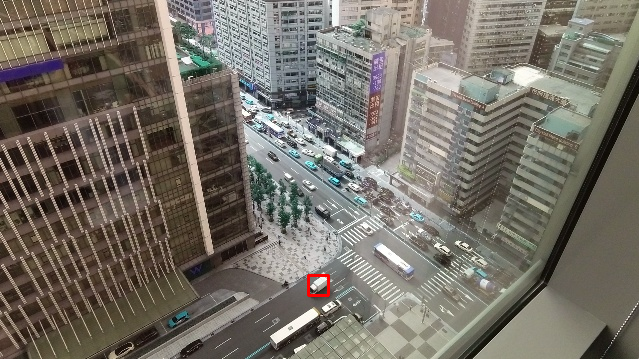

In [7]:
import random
from PIL import Image

temp_file = label_json[random.randint(0, len(label_json)-1)]
temp_bbox = temp_file.get('Label').get('objects')[0].get('bbox')
temp_img = cv2.imread(os.path.join(*[BASE_DIR_PATH, IMAGES_FOLDER_NAME, temp_file.get('External ID')]))
y,x,h,w = temp_bbox.get('top'), temp_bbox.get('left'), temp_bbox.get('height'), temp_bbox.get('width')
Image.fromarray(cv2.rectangle(temp_img, (x, y), (x+w, y+h), (255,0,0), 2))

## Plot-image-from-text

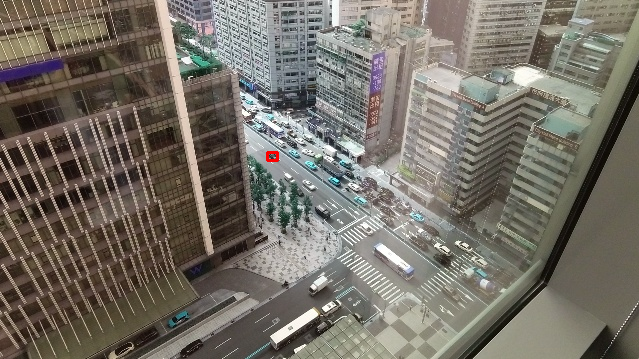

In [10]:
temp_txt_list = os.listdir(os.path.join(*[BASE_DIR_PATH, LABELS_FOLDER_NAME]))
temp_file_counter = len(temp_txt_list)
while True:
    temp_txt = temp_txt_list[random.randint(0, temp_file_counter-1)]
    if temp_txt.endswith('.txt'):
        break
    
with open(os.path.join(*[BASE_DIR_PATH, LABELS_FOLDER_NAME, temp_txt]), 'r') as f:
    d = f.read()

temp_img = cv2.imread(os.path.join(*[BASE_DIR_PATH, IMAGES_FOLDER_NAME, temp_file.get('External ID')]))
    
bx = d.split('\n')[-2].split(' ')
cx = int(float(bx[1]) * width)
cy = int(float(bx[2]) * height)
cw = int(float(bx[3]) * width)
ch = int(float(bx[4]) * height)

w, h = int(cw/2), int(ch/2)
x = cx-w
y = cy-h
cv2.rectangle(temp_img, (x, y), (cx+w, cy+h), (255,0,0), 2)
Image.fromarray(temp_img)

## Generate-specific-file

In [19]:
list_images_file_name = "{}.txt".format(IMAGES_FOLDER_NAME)
metadat_file_name = "{}.data".format(IMAGES_FOLDER_NAME)
ORIGIN_PATH = '../coco/images/{}/'.format(IMAGES_FOLDER_NAME)
category_file_name = "{}.names".format(IMAGES_FOLDER_NAME)

with open(os.path.join(*[BASE_DIR_PATH, list_images_file_name]), 'a') as file:
    print('Write {}'.format(list_images_file_name))
    for ig in os.listdir(os.path.join(*[BASE_DIR_PATH, IMAGES_FOLDER_NAME])):
        if not ig.startswith('.'):
            file_path = "{}/{}\n".format(ORIGIN_PATH, ig)
            file.writelines(file_path)

#FIXME: validation and testing data
writeLines = ['classes=1', 'train=data/{}'.format(list_images_file_name), 'names=data/{}'.format(category_file_name)]
with open(os.path.join(*[BASE_DIR_PATH, metadat_file_name]), 'a') as file:
    print('Write {}'.format(metadat_file_name))
    for lines in writeLines:
        file.writelines(lines+'\n')
        

category = ['car']
with open(os.path.join(*[BASE_DIR_PATH, category_file_name]), 'a') as file:
    print('Write {}'.format(category_file_name))
    for cat in category:
        file.writelines(cat+'\n')

Write drone2020_08_12.txt
Write drone2020_08_12.data
Write drone2020_08_12.names
